In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from glob import glob

In [ ]:
# 데이터셋의 경로
dataroot = "/content/drive/MyDrive/Breastcancer/train_image"

# dataloader에서 사용할 쓰레드 수
workers = 2

# 배치 크기
batch_size = 128

# 이미지의 크기/ 모든 이미지를 변환하여 64로 크기가 통일
image_size = 64

# 이미지의 채널 수
nc = 3

# 잠재공간 벡터의 크기 (예. 생성자의 입력값 크기)
nz = 100

# 생성자를 통과하는 특징 데이터들의 채널 크기
ngf = 64

# 구분자를 통과하는 특징 데이터들의 채널 크기
ndf = 64

# 학습할 에폭 수
num_epochs = 3

# 옵티마이저의 학습률
lr = 0.0003

# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5

# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정
ngpu = 1

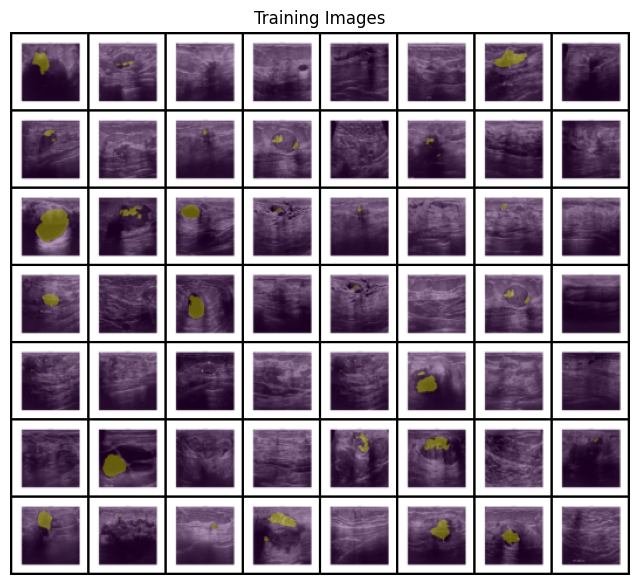

In [ ]:
# 우리가 설정한 대로 이미지 데이터셋을 불러오기
# 데이터셋 만들기
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                           ]))
# dataloader를 정의
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# GPU 사용여부를 결정
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 학습 데이터들 중 몇가지 이미지들 출력
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:56], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# ``netG`` 와 ``netD`` 에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# 생성자 코드

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력데이터 Z가 가장 처음 통과하는 전치 합성곱 계층
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 위의 계층을 통과한 데이터의 크기. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# 생성자 생성
netG = Generator(ngpu).to(device)

# 필요한 경우 multi-GPU 설정
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 모든 가중치의 평균을 0( ``mean=0`` ), 분산을 0.02( ``stdev=0.02`` )로 초기화하기 위해
# ``weight_init`` 함수를 적용
netG.apply(weights_init)

# 모델의 구조 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# 구분자 코드

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력 데이터의 크기는 ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# 구분자 생성
netD = Discriminator(ngpu).to(device)

# 필요한 경우 multi-GPU 설정
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 모든 가중치의 평균을 0( ``mean=0`` ), 분산을 0.02( ``stdev=0.02`` )로 초기화하기 위해
# ``weight_init`` 함수 적용
netD.apply(weights_init)

# 모델의 구조 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): Sigmoi

In [ ]:
# ``BCELoss`` 함수의 인스턴스 초기화
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터 생성
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 학습에 사용되는 참/거짓의 라벨
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저 생성
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# 학습 과정

# 학습상태를 체크하기 위해 손실값들 저장
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내에서 배치 반복
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) D 신경망을 업데이트: log(D(x)) + log(1 - D(G(z))) 최대화
        ###########################
        ## 진짜 데이터들로 학습
        netD.zero_grad()
        # 배치들의 사이즈나 사용할 디바이스에 맞게 조정
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터들로 이루어진 배치를 D에 통과
        output = netD(real_cpu).view(-1)
        # 손실값
        errD_real = criterion(output, label)
        # 역전파의 과정에서 변화도 계산
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터들로 학습
        # 생성자에 사용할 잠재공간 벡터 생성
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지 생성
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위 판별
        output = netD(fake.detach()).view(-1)
        # D의 손실값 계산
        errD_fake = criterion(output, label)
        # 역전파를 통해 변화도 계산 이때 앞서 구한 변화도에 더함(accumulate)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들 더함
        # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용
        errD = errD_real + errD_fake
        # D를 업데이트
        optimizerD.step()

        ############################
        # (2) G 신경망을 업데이트: log(D(G(z)))를 최대화
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨 이용
        # 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터 통과
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값과 다른 값이 나옴
        output = netD(fake).view(-1)
        # G의 손실값
        errG = criterion(output, label)
        # G의 변화도 계산
        errG.backward()
        D_G_z2 = output.mean().item()
        # G 업데이트
        optimizerG.step()

        # 훈련 상태 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들 저장
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값 저장
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/3][0/1]	Loss_D: 2.3335	Loss_G: 1.5811	D(x): 0.3164	D(G(z)): 0.5690 / 0.2733
[1/3][0/1]	Loss_D: 1.6172	Loss_G: 4.4714	D(x): 1.0000	D(G(z)): 0.7419 / 0.0305
[2/3][0/1]	Loss_D: 0.1980	Loss_G: 6.1036	D(x): 1.0000	D(G(z)): 0.1631 / 0.0040


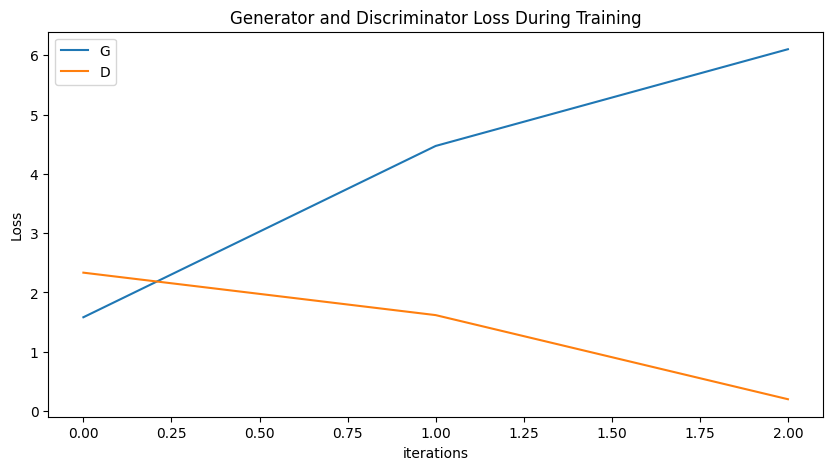

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

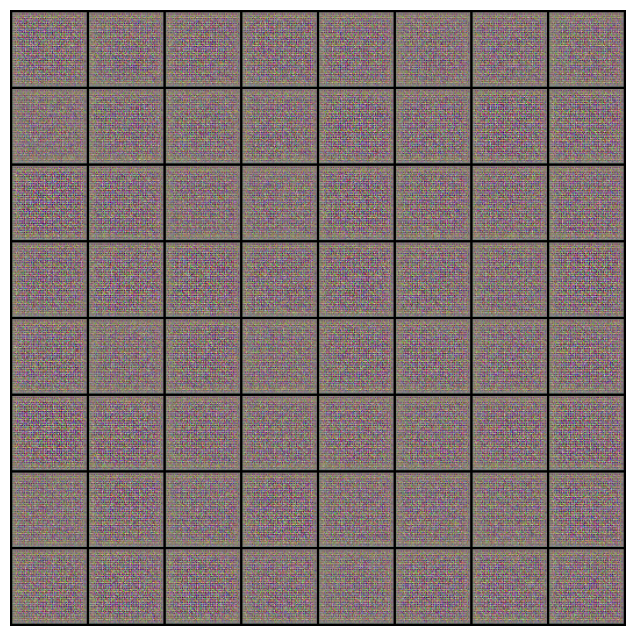

In [ ]:
from torchvision.utils import make_grid
from PIL import Image
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

# 가짜 이미지 시각화 및 저장
def visualize_images(img_list, epoch, save_path='generated_images_epoch'):
    # 가짜 이미지 시각화
    fake_images = img_list[-1].cpu().detach()
    grid_img = make_grid(fake_images, padding=2, normalize=True)

    # 시각화할 때는 필요 없는 차원 삭제
    grid_img = grid_img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

    # 시각화
    fig = plt.figure(figsize=(8, 8))
    plt.axis("off")
    #plt.title("Fake Images")
    plt.imshow(grid_img)

    # 이미지 저장
    save_filename = f'{save_path}_epoch_{epoch}.png'
    plt.savefig(save_filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()

# 학습 과정에서 img_list에 저장된 가짜 이미지 시각화 및 저장
visualize_images(img_list, epoch, save_path='generated_images')


In [ ]:
pip install pillow

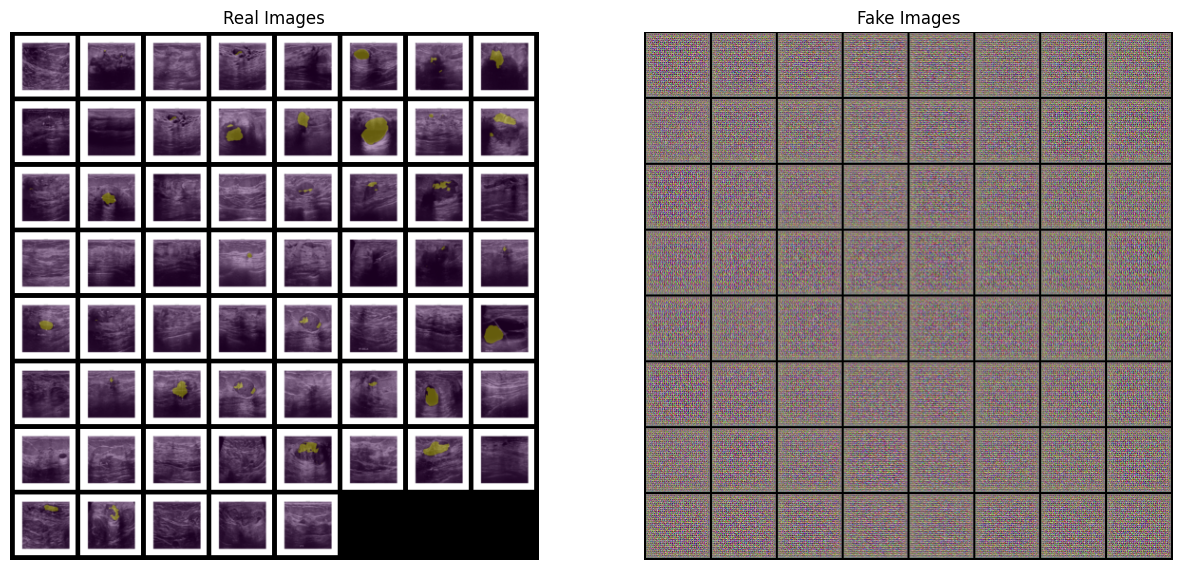

In [ ]:
# dataloader에서 진짜 데이터들을 가져오기
real_batch = next(iter(dataloader))

# 진짜 이미지들을 화면에 출력
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
print(real_batch[0].shape)
print(img_list[0].shape)

import numpy as np

# 리스트를 NumPy 배열로 변환
my_array = np.array(real_batch[0])

# 배열의 형태를 변경
real_batch = my_array.reshape(-1,64,64)  # -1은 해당 차원의 크기를 자동으로 조정하라는 의미

# 결과 확인
print(real_batch)

print(real_batch.shape)

torch.Size([61, 3, 64, 64])
torch.Size([3, 530, 530])
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 ...

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1

In [ ]:
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_fid(images1, images2):
    model = InceptionV3()

    def get_inception_activations(images, model):
      # 이미지 크기 변경
      images_resized = np.array([resize(img, (299, 299, 3), mode='reflect', anti_aliasing=True) for img in images])

      # 전처리
      images_resized = preprocess_input(images_resized)
      activations = model.predict(images_resized)
      return activations

    acts1 = get_inception_activations(images1, model)
    acts2 = get_inception_activations(images2, model)

    mu1, sigma1 = acts1.mean(axis=0), np.cov(acts1, rowvar=False)
    mu2, sigma2 = acts2.mean(axis=0), np.cov(acts2, rowvar=False)

    fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid

# 사용할 실제 이미지 데이터 생성
real_images = np.array(real_batch[0])  # 실제 이미지 데이터를 넘파이 배열로 변환

# FID 계산
fid_score = calculate_fid(real_images, img_list)
print("Frechet Inception Distance:", fid_score)

1/1 [==============================] - 2s 2s/step
Frechet Inception Distance: -3.853687517314125e+52


In [ ]:
pip install scikit-image

1/1 [==============================] - 4s 4s/step


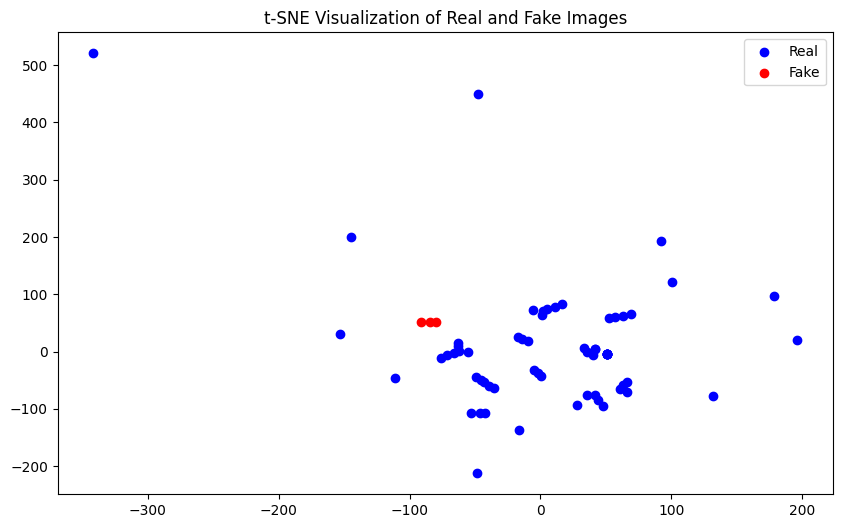

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize
from sklearn.manifold import TSNE

# Define the InceptionV3 model
model = InceptionV3()

def get_inception_activations(images, model):
    # 이미지 크기 변경
    images_resized = np.array([resize(img, (299, 299, 3), mode='reflect', anti_aliasing=True) for img in images])

    # 전처리
    images_resized = preprocess_input(images_resized)
    activations = model.predict(images_resized)
    return activations

# Now you can use the model in your t-SNE code
acts_real = get_inception_activations(real_batch[0], model)
acts_fake = get_inception_activations(img_list[0], model)

# The rest of your t-SNE code remains unchanged
# Combine real and fake features and labels
all_features = np.concatenate([acts_real, acts_fake])
all_labels = np.concatenate([np.ones(len(acts_real)), np.zeros(len(acts_fake))])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=1)
embedded = tsne.fit_transform(all_features)

# Separate embedded data back into real and fake for plotting
embedded_real = embedded[all_labels == 1]
embedded_fake = embedded[all_labels == 0]

# Plot t-SNE results
plt.figure(figsize=(10, 6))

plt.scatter(embedded_real[:, 0], embedded_real[:, 1], color='blue', label='Real')
plt.scatter(embedded_fake[:, 0], embedded_fake[:, 1], color='red', label='Fake')

plt.title('t-SNE Visualization of Real and Fake Images')
plt.legend()
plt.show()


In [ ]:
from PIL import Image
import os

def split_grid_image(input_path, output_folder, num_rows, num_cols):
    # 입력 경로에서 이미지 불러오기
    input_image = Image.open(input_path)

    # 그리드 이미지의 크기 가져오기
    img_width, img_height = input_image.size

    # 각 그리드의 크기 계산
    grid_width = img_width // num_cols
    grid_height = img_height // num_rows

    # 이미지 분리 및 저장
    for row in range(num_rows):
        for col in range(num_cols):
            # 이미지 영역 지정
            left = col * grid_width
            top = row * grid_height
            right = (col + 1) * grid_width
            bottom = (row + 1) * grid_height

            # 이미지 크기를 유지하면서 분리
            cropped_image = input_image.crop((left, top, right, bottom))

            # 이미지 크기가 그리드와 다를 경우, 흰색 배경 추가
            if cropped_image.size != (grid_width, grid_height):
                new_image = Image.new("RGB", (grid_width, grid_height), (255, 255, 255))
                new_image.paste(cropped_image, ((grid_width - cropped_image.width) // 2, (grid_height - cropped_image.height) // 2))
                cropped_image = new_image

            # 저장 폴더 생성
            os.makedirs(output_folder, exist_ok=True)

            # 이미지 저장
            save_path = os.path.join(output_folder, f"image_{row * num_cols + col + 1}.png")
            cropped_image.save(save_path)

# 입력 그리드 이미지의 경로 설정
input_image_path = '/content/generated_images_epoch_2.png'

# 출력 폴더의 경로 설정
output_folder_path = '/content/drive/MyDrive/Breastcancer/Unet_result'

# 그리드 크기 설정
num_rows = 8
num_cols = 8

# 그리드 이미지 분리 및 개별 이미지로 저장
split_grid_image(input_image_path, output_folder_path, num_rows, num_cols)
